In [38]:
%pylab inline
import fitsio
from collections import namedtuple
from itertools import islice
from scipy.stats import binned_statistic

plt.style.use(['ggplot', 'seaborn-talk'])

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [39]:
fname = 'out.fits'

infile = fitsio.FITS(fname)    

In [40]:
catalogue = infile['CATALOGUE'].read()

In [41]:
print(catalogue[:5])

[ (b'000008', 1.4205834865570068, -0.4169256389141083, 7314.89306640625, 0, 551.5742797851562, 0.8733820915222168, nan, nan, nan, nan, 0, 0, 0.0, [0.0, 0.0, 0.0], 0, b'', 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
 (b'000010', 1.4324060678482056, -0.4167901575565338, 6723.4501953125, 0, 105.51123046875, 0.9569383263587952, nan, nan, nan, nan, 0, 0, 0.0, [0.0, 0.0, 0.0], 0, b'', 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
 (b'000013', 1.4253469705581665, -0.41687023639678955, 6965.8720703125, 0, 372.386962890625, 0.8832467794418335, nan, nan, nan, nan, 0, 0, 0.0, [0.0, 0.0, 0.0], 0, b'', 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
 (b'000021', 1.400317907333374, -0.4171602129936218, 24545.091796875, 0, 1310.7181396484375, 1.0302526950836182, nan, nan, nan, nan, 0, 0, 0.0, [0.0, 0.0, 0.0], 0, b'', 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
 (b'000031', 1.407153606414795, -0.4171071946620941, 9367.658203125, -1, 1054.77978515625, 2.0005569458007812, 67.98377227783203, 3.8261489868164062, -4

In [42]:
jd_ref = 2456658.500000
def wd2jd(wd):
    return (wd / 86400.) + jd_ref

def jd2wd(jd):
    return (jd - jd_ref) * 86400.

assert isclose(wd2jd(jd2wd(20185)), 20185)

Synthetic objects have populated TRANS_PERIOD columns

In [43]:
fake_ind = catalogue['TRANS_PERIOD'] != 0.
fake_catalogue = catalogue[fake_ind]

In [44]:
fake_catalogue.dtype.names

('OBJ_ID',
 'RA',
 'DEC',
 'REF_FLUX',
 'CLASS',
 'CCD_X',
 'CCD_Y',
 'FLUX_MEAN',
 'FLUX_RMS',
 'MAG_MEAN',
 'MAG_RMS',
 'NPTS',
 'NPTS_CLIPPED',
 'SIGMA_XS',
 'CI',
 'IS_STD',
 'REAL_OBJ_ID',
 'SKIPDET',
 'TRANS_PERIOD',
 'TRANS_WIDTH',
 'TRANS_DEPTH',
 'TRANS_EPOCH',
 'TRANS_RP',
 'TRANS_RS',
 'TRANS_A',
 'TRANS_I')

In [45]:
Lightcurve = namedtuple('Lightcurve', 'phase flux')

We start by looking at fairly obvious cases. Pick objects which should give transit depths of ~2% and with periods of ~5 days.

In [46]:
fake_period = catalogue['TRANS_PERIOD'] / 86400.
fake_depth = catalogue['TRANS_DEPTH']
fake_width = catalogue['TRANS_WIDTH']

In [47]:
ind = np.where(
    (fake_depth > 0.02) & (fake_depth < 0.03) &
    (fake_period > 4) & (fake_period < 5) &
    ((fake_width / fake_period) > 0.02)
    )[0]
assert ind.size
print(ind.size)

5


/home/sw/work/NGTS/transit-injection/synthetic-transits/venv/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/home/sw/work/NGTS/transit-injection/synthetic-transits/venv/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater


In [48]:
chosen_ind = np.random.choice(ind)
chosen_obj_id = catalogue['OBJ_ID'][chosen_ind]

print('Chosen object {}, period: {}, depth: {}, index: {}'.format(chosen_obj_id, fake_period[chosen_ind], fake_depth[chosen_ind], chosen_ind))

Chosen object b'F01311', period: 4.031503250945403, depth: 0.02470246338829432, index: 9816


In [67]:
real_obj_id = '{:06d}'.format(int(catalogue['REAL_OBJ_ID'][chosen_ind].decode('utf-8').strip())).encode('utf-8')

In [69]:
(catalogue['OBJ_ID'] == real_obj_id).any()

True

In [71]:
real_ind = np.where(catalogue['OBJ_ID'] == real_obj_id)[0].min()

In [72]:
def transit_model(width, period, depth):
    normwidth = width / period
    xpoints = np.array([-0.2, -normwidth / 2., -normwidth / 2., normwidth / 2., normwidth / 2., 0.8])
    ypoints = np.array([1., 1., 1. - depth, 1. - depth, 1., 1.])
    return xpoints, ypoints

In [73]:
def get_by_ind(hdu, index):
    return infile[hdu][index:index+1, :].ravel()

/home/sw/work/NGTS/transit-injection/synthetic-transits/venv/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/sw/work/NGTS/transit-injection/synthetic-transits/venv/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide


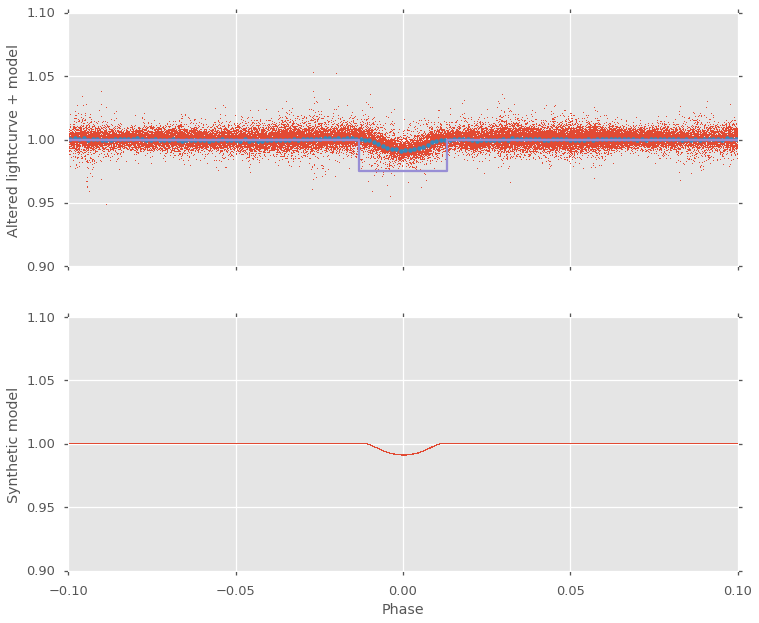

In [80]:
hjd = get_by_ind("HJD", chosen_ind)
flux = get_by_ind("FLUX", chosen_ind)

xlims = (-0.1, 0.1)
ylims = (0.9, 1.1)
nplots = 2

def med_in_plot(d):
    ind = (d >= ylims[0]) & (d <= ylims[1])
    return np.median(d[ind])

fig, axes = plt.subplots(nplots, 1, sharex=True, sharey=True, figsize=(12, 5 * nplots))

med_flux = np.median(flux)
period = catalogue['TRANS_PERIOD'][chosen_ind]
epoch = catalogue['TRANS_EPOCH'][chosen_ind]
phase = ((hjd - epoch) / period) % 1
phase[phase > 0.8] -= 1.0
normflux = flux / med_flux
axes[0].plot(phase, normflux, ',')
by, bx, _ = binned_statistic(phase, normflux, bins=150, range=xlims, statistic=med_in_plot)
bx = (bx[:-1] + bx[1:]) / 2.
axes[0].plot(bx, by, '.')

model_x, model_y = transit_model(catalogue['TRANS_WIDTH'][chosen_ind], catalogue['TRANS_PERIOD'][chosen_ind],
                                 catalogue['TRANS_DEPTH'][chosen_ind])
axes[0].plot(model_x, model_y)

trueflux = get_by_ind("FLUX", real_ind)
lc_model = flux / trueflux
axes[1].plot(phase, lc_model, ',')

axes[0].set(ylabel='Altered lightcurve + model')
axes[1].set(xlabel='Phase', ylabel='Synthetic model')

for axis in axes:
    axis.set(xlim=xlims, ylim=ylims)


In [78]:
ind = np.isfinite(lc_model)

In [79]:
lc_model[ind].min(), lc_model[ind].max()

(0.9907279, 1.0000905)